# Introducción


En este cuaderno, se resolverá el [TPC02 - Estructura a Gran Escala](https://drive.google.com/file/d/1nBJmIGJQ86gFNLgH_z5aKbzZr0dcMXZc/view). En el mismo se podrán leer los resultados de los ejercicios, el código implementado para la resolución y comentarios sobre las tareas realizadas.
Para cada ejercicio, se requiere trabajar con una base de datos distinta. Algunas redes están dadas por archivos .txt; otras, vienen como archivos .gml. 
[Aquí un enlace a los datos](https://drive.google.com/open?id=1UDV9lRFZI9o9kHg7SS4jRlwAzHuZyCcu). Para poder ejecutar el archivo, deben estar subidos al directorio del cuaderno donde se lo abre para poder cargarlo. 

Importamos librerias a utilizar 

In [39]:
import networkx as nx
import random as random
import numpy as np
import matplotlib.pyplot as plt
import os
import time

In [15]:
#creamos función para abrir .txt
def abrir_txt(nombre_archivo):
    archivo=open(nombre_archivo)
    data=[]
    for linea in archivo:
        linea=linea.strip()
        if 'netscience' in nombre_archivo:
            columna=linea.split(',' and ';')
        else:
            columna=linea.split()
        columna = [columna[0],columna[1]]
        data.append(columna)
    return data

# Ejercicio 1

Consideramos para este ejercicio las siguientes 4 redes (asumiendo que no son dirigidas ni pesadas):
* La red de interacciones de proteínas de la levadura, en el archivo yeast_Y2H.txt.
* La red de internet del archivo as-22july06.gml.
* La red de conexiones del sistema eléctrico de los estados del oeste de EEUU, del archivo power_enlaces.txt.
* La red de colaboraciones científicas del archivo netscience_edgelist.txt.

## Inciso (a)

In [16]:
redes = {'Y2H': './data/yeast_Y2H.txt', 
         'Sistema Electrico': './data/power_enlaces.txt',
         'Papers': './data/netscience_edgelist.txt',
         'Internet': "./data/as-22july06_edgelist.txt"
         }

#funcion para abrir redes
def info_red(red):
    nombre, extension = os.path.splitext(red)
    if extension != '.txt':
        Red = nx.read_gml('./data/as-22july06.gml')
    else:
        lista_de_enlaces = abrir_txt(red)
        Red = nx.Graph()
        Red.add_edges_from(lista_de_enlaces)
    Grafo = Red
    Grados = Red.degree()
    return Grafo,Grados

def distribucion_grado_normal(lista_grados):
    hist,binedges = np.histogram(lista_grados,density=True,bins=max(lista_grados))
    bincenters = np.round(np.mean(np.vstack([binedges[0:-1],binedges[1:]]), axis=0))
    Hist = np.array((bincenters,hist)).T
    Hist = np.array([i for i in Hist if i[1]*1 != 0.0]).T #me saco de encima los grados con P_{k} = 0
    
    return Hist[0],Hist[1]
    
def cumulative_binning(lista_grados):
    lista_grados = np.flip(np.sort((lista_grados)))
    ranking = np.arange(1, len(lista_grados) + 1)
    pk = ranking / len(ranking)                  
    return lista_grados, pk     

In [17]:
#Creamos diccionario de grados
grados_dict = {}
for i, red in enumerate(redes.keys()):
    Grafo, Grados = info_red(redes[red])
    lista_grados= [val for (node, val) in Grados]
    grados_dict[red] = lista_grados

Graficamos para cada red.

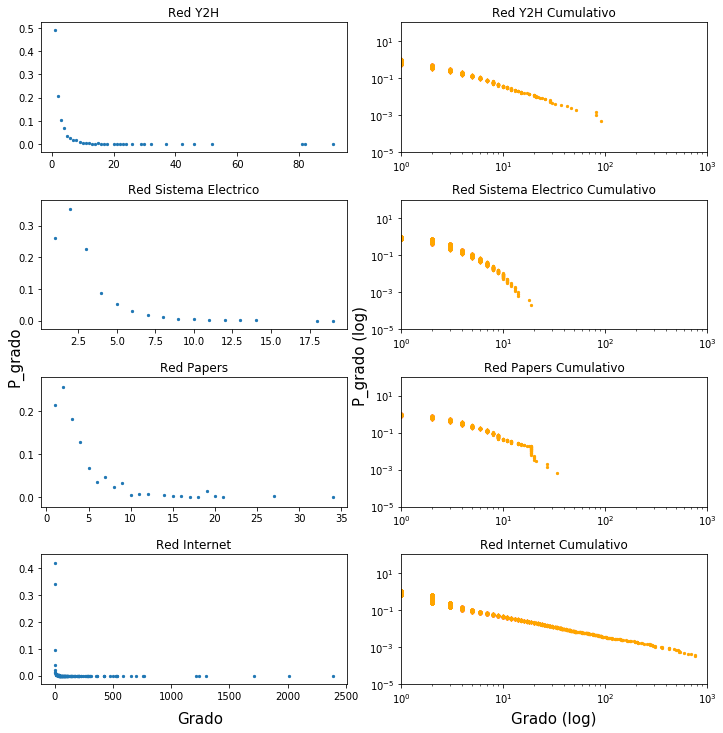

In [18]:
fig, axes = plt.subplots( nrows=4,ncols=2, figsize=(10, 10))

for i,red  in enumerate(redes.keys()):
    lista_grados = grados_dict[red]
    #plot distribucion regular
    x1,y1 = distribucion_grado_normal(lista_grados)
    axes[i,0].scatter(x1,y1,s=5)
    axes[i,0].set_title(f"Red {red}")
        
    #plot distribucion cumulativa
    x2,y2 = cumulative_binning(lista_grados)
    axes[i,1].scatter(x2,y2,color='orange',s=5)
    axes[i,1].set_title(f"Red {red} Cumulativo")
    axes[i,1].set_yscale("log")
    axes[i,1].set_xscale("log")
    axes[i,1].set_xlim(10**0,10**3)
    axes[i,1].set_ylim(10**-5,10**2)

plt.tight_layout()
fig.text(0.3, -0.01, 'Grado', ha='right', size = 15)
fig.text(0.70, -0.01, 'Grado (log)', ha='left', size = 15)
fig.text(0, 0.5, 'P_grado', va='center', rotation='vertical',  size = 15)      
fig.text(0.48, 0.5, 'P_grado (log)', va='center', rotation='vertical',  size = 15)
plt.show()

## Inciso (b)

A partir de los graficos del inciso anterior, se pone en evidencia el comportamiento de tipo 'power law' de algunas de las redes, donde la probabilidad de
que un nodo tenga un dado grado $k$ está dada por la ecuación: $P_k = Ck^{−γ}$. 

Al observar el gráfico de bineado cumulativo en escala log-log identificamos las dos redes que presentan un comportamiento lineal, es decir que se ajustan mejor a una power law. Estas dos redes son la red Internet y la red Y2H. 

En el caso de la red del Sistema Eléctrico y la red de Papers el comportamiento que se observa en las mayores escalas parece ser de tipo "cola pesada" que indica que la red tiene un grado $k$ de saturacion. Esto es el llamado "efecto de borde" en redes reales donde existe un grado máximo por propiedades estructurales de la red.

## Inciso (c)
Buscamos efecto de borde dado por el tamaño finito de las redes, y para cuáles
redes es más o menos apreciable. 

Se puede apreciar un efecto de borde pronunciado en las redes de Sistema Electrico y de los Papers. Para poder discernir el $\gamma$ se linealiza esta funcion de distribución.
Lo que vamos a hacer es redefinir $P_{k}$ para esta red y mostrar el regimen lineal a partir de la distribución $P_{k}'$.

Para una red con efectos de borde tenemos que:
$ p_{k} = a(k+k_{sat})^{-\gamma}e^{-\frac{k}{k_{cut}}}$.

Multiplicando por $e^{\frac{k}{k_{cut}}}$ en cada lado definimos pk':
$p_{k}' = p_{k}e^{ \frac{k}{k_{cut}}}= a(k+k_{sat})^{-\gamma}$


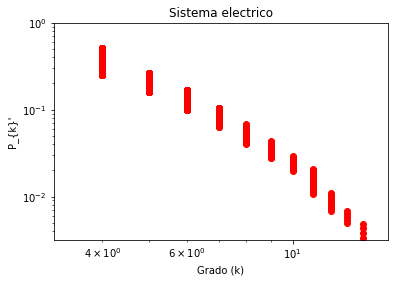

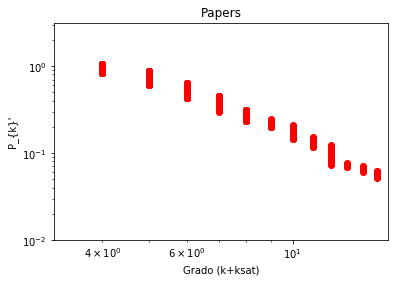

In [19]:
def pk_prima(lista_grados,kcut):
    k,pk = cumulative_binning(lista_grados)
    pk_p = np.array(pk)*np.exp(np.array(k)/ kcut)

    return np.array(k) , pk_p

#ploteamos la nueva funcion de distribucion del grafo Sistema Electrico

ksat = 1 #definimos k-sat a ojo
kcut = 15 #lo mismo para k-cut
k,pk_p =  pk_prima(grados_dict['Sistema Electrico'],kcut)
plt.figure()
plt.scatter(k+ksat,pk_p,color = 'red')
plt.yscale("log")
plt.xscale("log")
plt.ylabel("P_{k}'")
plt.xlabel('Grado (k)')
plt.xlim(10**0.5,10**1.2)
plt.ylim(10**-2.5,10**0)
plt.title("Sistema electrico")
plt.show()

#ploteamos la nueva funcion de distribucion del grafo Papers

ksat = 3 #definimos k-sat a ojo
kcut = 20 #lo mismo para k-cut
k,pk_p =  pk_prima(grados_dict['Papers'],kcut)
plt.figure()
plt.scatter(k+ksat,pk_p,color = 'red')
plt.yscale("log")
plt.xscale("log")
plt.ylabel("P_{k}'")
plt.xlabel('Grado (k+ksat)')
plt.xlim(10**0.5,10**1.2)
plt.ylim(10**-2,10**0.5)
plt.title("Papers")
plt.show()

def pk_primak(lista_grados,kcut):
    k,pk = cumulative_binning(lista_grados)
    pk_p = np.array(pk)*np.exp(np.array(k)/ kcut)
    dictt = {}
    dictt['k'] = k
    dictt['pk'] = pk
    dictt['pk_p'] = pk_p
    return dictt  

Una vez que encontramos esta distribución con una regimen lineal, la podemos someter a las estimaciones de $\gamma$ con las otras distribuciones.

## Inciso (d)

Para ajustar el parámetro $\gamma$ utilizaremos la estimación de parámetros del modelo estadístico Maximum-likelihood estimation (MLE). 
Comenzaremos visualizando los datos con un bineado logarítmico que nos permite apreciar el régimen lineal generado por el binneado y ajustar correctamente el parámetro $\gamma$. 
Aplicaremos este modelo estadístico sólo para la distribucion la red de internet (NetScience). Para las de Papers y el sistema Electrico utilizaremos la distribucion P

Para estimar la cantidad de bins para el bineado logaritmico utilizaremos la regla de Scott$^{[1]}$:
(https://en.wikipedia.org/wiki/Histogram#Scott%27s_normal_reference_rule)

El razonamiento es el siguiente:

Como los datos estan bien aproximados por una distribución logo-normal, al utilizar bines logarítmicos los datos van a tener una distribución aproximadamente normal. Asi que uso Scott's rule que minimiza el promedio 

[1] Scott, David W. (1979). “On optimal and data-base
d histograms”. Biometricka 66 (3): 605-610

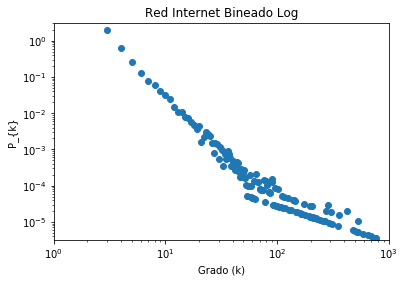

In [20]:
from astropy.stats import scott_bin_width


def log_binning(lista_grados):
    
    #estimo los bins
    ancho_medio, binedges_medio = scott_bin_width(lista_grados,return_bins=True)
    num_bins = int(max(lista_grados)/ancho_medio)
    espaciado_log = np.logspace(0, 4, endpoint=True, base=10,num=num_bins)
    
    hist,binedges = np.histogram(lista_grados,espaciado_log,density=True)
    bincenters = np.round(np.mean(np.vstack([binedges[0:-1],binedges[1:]]), axis=0))
    Hist = np.array((bincenters,hist)).T
    Hist = np.array([i for i in Hist if i[1]*1 != 0.0]).T #me saco de encima los grados con P_{k} = 0
    
    return Hist[0],Hist[1]


#plot bineado logaritmico
x,y = log_binning(grados_dict['Internet'])
plt.figure()
plt.scatter(x,y)
plt.title(f"Red Internet Bineado Log")
plt.yscale("log")
plt.xscale("log")
plt.ylabel('P_{k}')
plt.xlabel('Grado (k)')
plt.xlim(10**0,10**3)
plt.ylim(10**-5.5,10**0.5)
plt.show()

Este método para estimar la cantidad de bines no resultó óptimo ya que predijo más bines de los necesario.
Utilizaremos la función devuelta pero con un bineado según la definición de un espaciado logarítmico:
    $b_{i} = b_{i-1} + 2^{i}$

[0, 1, 3, 7, 15, 31, 63, 127, 255, 511, 1023, 2047, 4095]


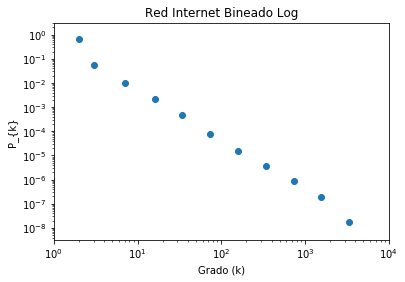

In [21]:
def log_binning_2(red):
    b = [0]
    i=0
    
    while b[-1] <= max(lista_grados):
        bi = b[-1] + 2**i
        b.append(bi)
        i += 1
    print(b)  
    num_bins = len(b)
    espaciado_log = np.logspace(0, 4, endpoint=True, base=10,num=num_bins)
    
    hist,binedges = np.histogram(lista_grados,espaciado_log,density=True)
    bincenters = np.round(np.mean(np.vstack([binedges[0:-1],binedges[1:]]), axis=0))
    Hist = np.array((bincenters,hist)).T
    Hist = np.array([i for i in Hist if i[1]*1 != 0.0]).T #me saco de encima los grados con P_{k} = 0
    
    return Hist[0],Hist[1]


#plot bineado logaritmico
x,y = log_binning_2(grados_dict['Internet'])
plt.figure()
plt.scatter(x,y)
plt.title(f"Red Internet Bineado Log")
plt.yscale("log")
plt.xscale("log")
plt.ylabel('P_{k}')
plt.xlabel('Grado (k)')
plt.xlim(10**0,10**4)
plt.ylim(10**-8.5,10**0.5)
plt.show()

Ajustamos para ver si se cumplen las leyes de potencia para cada red:
$p(k) = Ck^{-\gamma}$.
Con el bineado logaritmico nos queda:
$C = (\gamma - 1) K_{min}^{(\gamma-1)}$.
Donde $K_min$ es el k que maximiza la probabilidad L:
$ L(k|\gamma) = \prod_{i=1}^{N} p(k) = \prod_{i=1}^{N} \frac{\gamma -1}{K_{min}} (\frac{k_i}{K_{min}})^{-\gamma} $


[0, 1, 3, 7, 15, 31, 63, 127, 255, 511, 1023, 2047, 4095]


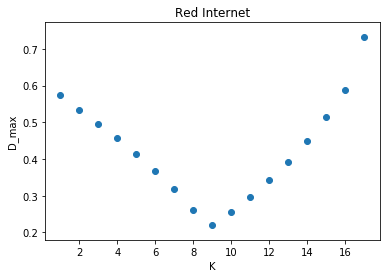

In [22]:
def gamma(N,k,kmin):
    return 1 + N * 1/(np.sum(np.log(k/(kmin-0.5))))

def L_real(pk):
    lista_L = []
    for i in range(len(pk)):
        L_i = np.prod(pk[0:i+1])
        lista_L.append(L_i)
    return np.array(lista_L)

def L(N,k,kmin):
    lista_L = []
    for i in k:
        L_i = np.prod(((gamma(N,k,kmin)-1)/kmin)*((i/kmin)**(-gamma(N,k,kmin))))
        lista_L.append(L_i)
    return np.array(lista_L)

#esta funcion es para probar distintos kmin y ver cual kmin maximiza la prob
def D_max(N,k,kmin):
    L_aproximacion = L(N,k,kmin)
    L_datos = L_real(pk)
    return np.max(np.absolute(L_datos - L_aproximacion))
    
#me creo un dict en donde van a estar los Kmin en funcion de D_max
Kmin = {}
k,pk = log_binning_2(grados_dict[red])
N = len(k)
Ds = []
kmin = range(1,18)
for j in kmin:
    D = D_max(N,k,j)
    Ds.append(D)   
Kmin[red] = kmin[Ds.index(min(Ds))]

#ploteo
plt.scatter(kmin,Ds)
plt.title(f"Red {red}")
plt.ylabel('D_max')
plt.xlabel('K')
plt.show()

Buscamos el $K_min$ que minimiza a la función D y utilizamos ese valor para estimar el valor $\gamma$

In [23]:
print(f"El Kmin de la red es {Kmin['Internet']} ")
print(f"El gamma estimado es {np.round(gamma(N,k,Kmin['Internet']),3)}") 
      

El Kmin de la red es 9 
El gamma estimado es 1.463


Ahora pasamos a averiguar las $\gamma$ de las funciones de distribucion $P_{k}'$ calculados en el inciso c.
Para eso hacemos ajustamos la función sabiendo que $p_{k}' = p_{k}e^{ \frac{k}{k_{cut}}}= a(k+k_{sat})^{-\gamma}$.


In [24]:
from scipy.optimize import curve_fit

def pk_prima_real_e(k,a,gama):
    return a*((k+14)**(-gama))

def pk_prima_real_p(k,a,gama):
    return a*((k+20)**(-gama))

k_electrico,pk_p_electrico =  pk_prima(grados_dict['Sistema Electrico'],14)  
k_papers,pk_p_papers =  pk_prima(grados_dict['Papers'],20)

param_electrico, param_cov_electrico = curve_fit(pk_prima_real_e,k_electrico,pk_p_electrico, p0=[2,1.5])
param_papers, param_cov_papers = curve_fit(pk_prima_real_p,k_papers,pk_p_papers, p0=[2,1.5])

print(f"El gamma estimado de la red Sistema Electrico es {np.round(param_electrico[1],3)} +- {np.round(np.sqrt(param_cov_electrico[1][1]),3)}")
print(f"El gamma estimado de la red Papers es {np.round(param_papers[1],3)} +- {np.round(np.sqrt(param_cov_papers[1][1]),3)}")

El gamma estimado de la red Sistema Electrico es 6.91 +- 0.043
El gamma estimado de la red Papers es 6.641 +- 0.053


## Inciso (e)

Un nodo tomado al azar de una red cuya distribución de grado sigue una ley de potencia puede tener valores muy alejados de $ \langle k \rangle$. No existe una escala característica.  Un nodo crece (en términos de enlaces y grado) proporcionalmente al tamaño que tiene, sin que haya un parámetro de escala. Si bien podíramos sacar un promedio, no sería representativo. Pueden presentarse grandes fluctuaciones en el grado ($ \langle k^2 \rangle >> \langle k \rangle$). Típicamente presentan outliers (hubs).

# Ejercicio 2
En el paper de Barabasi, comparan dos mecanismos de generación de redes aleatorias no dirigidas para explicar las distribuciones tipo power law observadas en muchos tipos de redes muy diversos. En este ejercicio, realizamos tres tipos redes aleatorias diferentes. 
## Inciso (a)
Armamos un código para generar una red aleatoria tipo Erdos Renyi, con $n$ cantidad de nodos
y aproximadamente $m$ cantidad de enlaces. Este tipo de red consiste en simplemente tomar
$n$ nodos y enlazar cada par con una probabilidad $p$.

<ins>Aclaracion:</ins> Para optimizar los tiempos de ejecucion de las funciones armamos una que exclusivamente devuelva $m$ (cantidad de enlaces) y otra que devuelva $edges$ (vector de enlaces). La construcción es la misma, pero sirven propositos distintos. Para el **caso i.** interesa unicamente el valor de $m$ en funcion de valores de p. Y para el **caso ii.** interesa armar la red para un unico valor de p.

In [26]:
#Inicialmente creo una funcion que devuelva m en funcion de n y p (p es un vector)
def ErdosRenyi_m(n,p_vect):
    m = 0
    #Itero sobre los pares i-j
    for i in range(n):
        for j in range(i+1,n):
            random_sample = random.random()
            if random_sample < p:
                m+=1
    return(m)

#Creo una funcion que devuelve el listado de edges en funcion de n y p
def ErdosRenyi_edges(n,p):
    edges = []
    #Itero sobre los pares i-j
    for i in range(n):
        for j in range(i+1,n):
            random_sample = random.random()
            if random_sample < p:
                edges.append((i,j))
    return(edges)

### Caso i.
Armamos una red con $10000$ nodos y comprobamos que se cumple la relación teórica $m \cong \frac{pn(n − 1)}{2}$.

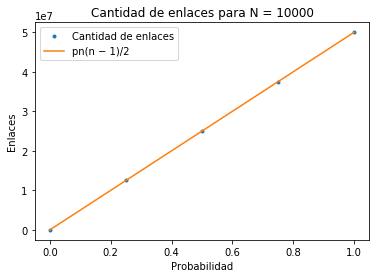

In [83]:
# Tarda aprox 40s en correr
n = 10000 #cantidad de nodos
p_vect = np.linspace(0,1,5) # probabilidad de enlazar
m = []
for p in p_vect:
    m.append(ErdosRenyi_m(n,p))
    
plt.plot(p_vect,m,'.',label = 'Cantidad de enlaces')
m_teorico=p_vect * n * (n - 1) / 2
plt.plot(p_vect, m_teorico, label = 'pn(n − 1)/2')
plt.title(f'Cantidad de enlaces para N = {n}')
plt.xlabel("Probabilidad")
plt.ylabel("Enlaces")
plt.legend()
plt.show()

Es evidente del grafico que la relacion $m \cong  pn(n − 1)/2$ se cumple, esto se debe a que la cantidad de enlaces $m$, si la probabilidad fuera 1, seria el número de combinaciones sin repetición de 2 elementos elegidos entre los n. Usando la formula de combinatoria esto termina siendo $n(n-1)/2$. Si luego en cada iteracion agregamos que $p<1$, el valor mas probable termina siendo $pn(n-1)/2$.



### Caso ii.
Con la misma red, mostramos que cumple $\langle ki \rangle = p(n − 1)$. 


Tomamos de ejemplo la red con $p=0.1$ y utilizamos la funcion *ErdosRenyi_edges(n,p)* armada anteriormente. Usamos un valor de $p$ bajo para que la cantidad de enlaces agregar sea de un orden menor.

In [28]:
#Tarda aprox 8s
n = 10000 #cantidad de nodos
p = 0.1
edges = ErdosRenyi_edges(n,p)

In [30]:
#Tarda aprox 7s
#Genera la red con los nodos, sin conectar
Red_ErdosRenyi = nx.empty_graph(n) 
Red_ErdosRenyi.add_edges_from(edges)

In [31]:
#Calcula el grado medio
k_sum = 0
for node in Red_ErdosRenyi.nodes():
    k_sum += Red_ErdosRenyi.degree(node)
k_mean = k_sum / n

print(f"〈ki〉= {k_mean} \n p(n-1) = {p*(n - 1)}")

〈ki〉= 999.8204 
 p(n-1) = 999.9000000000001


Podemos ver que en la red del ejemplo la relacion se cumple. Esto se debe a que el grado medio se puede redefinir de la siguiente manera:
$$ \left \langle ki \right \rangle = \sum_{i}^{N} \frac{ki}{N} = \sum_{i,j}^{N} \frac{A_{ij}}{2N} = \frac{pn(n-1)/2}{2n} = p(n-1) $$
Donde $A_{ij}$ es la matriz de adyacencia, y el factor $2N$ se agrega debido a que al iterar sobre $i$ y $j$, se recorre cada enlace dos veces (debido a que la matriz es simétrica).

In [32]:
#Defino una funcion para generar una red de tipo Erdos Renyi en base a n y m
#Tarda aproximadamente 16 s para una red de n = 10000 y p = 0.1
def Red_Erdos_Renyi(n,m):
    p = m/( n * (n-1)/ 2 )
    edges = ErdosRenyi_edges(n,p)
    #Genera la red con los nodos, sin conectar
    Red = nx.empty_graph(n) 
    Red.add_edges_from(edges)
    return Red

## Inciso (b) 
Armamos un código para generar una red aleatoria, con $n$ cantidad de nodos y un grado inicial $k_0$ fijo e igual para cada nodo.
Este tipo de red consiste en comenzar con $k_0$ nodos de grado $k_0$ e ir agregando un nodo de grado $k_0$ en cada paso. Los nodos ya agregados irán aumentando su grado al conectarse con los nodos nuevos que se vayan agregando. La manera de conectar un nodo nuevo a los existentes es aleatoria, donde el enlace entre el nuevo nodo y uno existente ocurre con igual propabilidad para todos los nodos existentes. Es decir, la probabilidad de que el nodo nuevo se enlace a uno existente es: $P = \frac{1}{N}$. Donde N son todos los nodos existentes en ese paso.

In [33]:
def Aleatoria_n_k0(n,k0):
    #Comienza con k0 nodos de grado k0
    Red = nx.complete_graph(k0)
    
    for paso in range(k0,n):
        nodos_a_enlazar = np.random.choice(np.arange(0,paso), size = k0)
        enlaces_nuevos = []
        for nodo in nodos_a_enlazar:
            enlaces_nuevos.append((nodo, paso))
        Red.add_edges_from(enlaces_nuevos)
    return Red

In [34]:
k0 = 10
n = 10000
Red_aleatoria_2 = Aleatoria_n_k0(n,k0)

Para este tipo de red, la cantidad de enlaces corresponde a la suma de los enlaces de la red completa inicial mas la suma de los k0 enlaces agregados uno por uno: 
$$ m= k_0(k_0-1)/2 + (n-k_0)k_0 $$

De esta manera de obtiene la siguiente formula para la relacion entre $k_0$ n y m:
$$0 =- \frac{1}{2} k_0^{2} + \left (  n-\frac{1}{2}\right ) k_0 - m$$

Con lo cual los $k_0$ que generan una red de n nodos y ~m enlaces son el entero positivo mas cercano a las raices reales y positivas de esa ecuacion. 

In [35]:
#Por ejemplo tomamos n=100, m=1000
n = 100
m = 1000
c = [-0.5 , n - 0.5 , -m]
k0 = [round(x) for x in np.roots(c) if np.isreal(x) and x > 0][0]
m_obtenido = k0*(k0-1)/2 + (n-k0)* k0
print(f"Para n = {n}, m = {m}, el k0 obtenido con este metodo es {k0} y genera {m_obtenido} enlaces.")

Para n = 100, m = 1000, el k0 obtenido con este metodo es 188.0 y genera 1034.0 enlaces.


In [36]:
def Red_aleatoria(n,m):
    c = [-0.5 , n - 0.5 , -m]
    k0 = min([round(x) for x in np.roots(c) if np.isreal(x) and x > 0])
    #En caso que devuelva k0=0, lo redefino como 1
    if k0 == 0: k0 = 1
    Red = Aleatoria_n_k0(n,int(k0))
    return Red  

## Inciso (c) 
Armamos un código para generar una red aleatoria tipo Barabasi, con $n$ cantidad de nodos y un grado inicial $k_0$ fijo e igual para cada nodo. 
Este tipo de red consiste en comenzar con pocos nodos de grado $k_0$ e ir agregando un nodo de grado $k_0$ en cada paso. Los nodos ya agregados irán aumentando su grado al conectarse con los nodos nuevos que se vayan agregando. La manera de conectar un nodo nuevo a los existentes es aleatoria, determinada por una probabilidad proporcional al grado de cada nodo existente. Es decir, la probabilidad de que el nodo nuevo se enlace a uno existente (i) es: $P = \frac{k_i}{\sum{j}k_j}$. Donde la sumatoria es sobre todos los nodos existentes. Para lo mismo, utilizamos una función de Numpy.Random.choice que elije de una lista con una dada probabilidad para cada elemento. 


In [37]:
import numpy as np
def barabasi(k_0, final_nodes):
    #m es el grado de los nodos iniciales y a la vez la cantidad de enlaces que agrego por iteracion
    
    new_node = k_0
        
    G = nx.complete_graph(k_0) #primero un grafo completo
    G_dict = {key: k_0-1 for key in range(k_0)} #usamos un dict para no recorrer siempre la red 
    
    for step in range(final_nodes - k_0):
        nodes_to_add = add_edges(G_dict, k_0)      
        G.add_node(new_node)
        G_dict[new_node] = k_0
        
        for node in nodes_to_add:
            G.add_edge(new_node, node)
            G_dict[node] += 1
                    
        new_node += 1
        
    return G

        
def add_edges(G_dict, k_0):
    nodes_probs = []
    nodes = list(G_dict.keys())
    total_degree = sum(G_dict.values())
    
    for node in nodes:
        node_degr = G_dict[node]
        node_prob = node_degr / total_degree if total_degree > 0 else 1/len(nodes) #excepción por si no tiene grado
        nodes_probs.append(node_prob) #probabilidad definida en el enunciado
        
    random_nodes = np.random.choice(nodes, size = k_0, p = nodes_probs, replace = False) #no elige dos veces el mismo
             
    return random_nodes

Armamos redes con $n = 10000$ y comprobamos que cumple la relación: $ enlaces \cong k_0 n$
Para lo mismo generamos 10 redes con $k_0$ aleatorios dentro de un rango (la idea de estos grafos es empezar con número 'pequeño' de nodos). En este caso el rango era de $0$ a $50$ que es, a lo sumo, un $0.5 \%$ del total de nodos $n$.

Creamos un diccionario que para cada red nos guarda su $k_0$, la diferencia entre los enlaces y el valor teórico y el porcentaje que eso representa del total. 

In [44]:
m_dict = {}
n = 10000
times = 10

for _ in range(times):
    start = time.time()
    k_0 = np.random.randint(0,50)
    Network = barabasi(k_0, n)
    end = time.time()
    num_edges = Network.number_of_edges()
    diff = abs(num_edges - k_0 * n)
    diff_percent = diff / num_edges * 100
    m_dict[k_0] = num_edges , diff, diff_percent
    print(f"Red {_}, tardó  {round(end - start, 2)} s")

Red 0, tardó  13.66 s
Red 1, tardó  13.44 s
Red 2, tardó  13.62 s
Red 3, tardó  14.4 s
Red 4, tardó  16.76 s
Red 5, tardó  14.73 s
Red 6, tardó  15.73 s
Red 7, tardó  15.37 s
Red 8, tardó  15.43 s
Red 9, tardó  16.13 s


In [45]:
mean = np.round(np.array([m_dict[k][2] for k in m_dict]).mean(), 2)
std = np.round(np.array([m_dict[k][2] for k in m_dict]).std(),2)

print(f' El porcentaje que representa la diferencia de enlaces presentes y el valor teórico es, para {times} redes: \n ({mean} + {std})%')

 El porcentaje que representa la diferencia de enlaces presentes y el valor teórico es, para 10 redes: 
 (0.11 + 0.05)%


Graficamos los valores esperados y el número de enlaces de cada red en función de su $k_0$. Podemos ver que la relación se cumple ya que cada nodo agregado ($n - k_0$) por paso crea $k_0$ enlaces nuevos a los $\frac{n (n-1)}{2}$ originales de un grafo completo (de entrada tenemos $k_0$  menos enlaces de lo predicho por la teoría.


Por como está definida random.choice puede elegir varias veces el mismo nodo, con lo cual hay nuevos nodos que generan menos de $k_0$ enlaces. Para cambiar esto, se usa la opción "replace = False" que asegura no estar sacando dos veces el mismo. De no ser así, tanto esa diferencia como los $k_0$ iniciales contribuirían a la diferencia calculada anteriormente. 


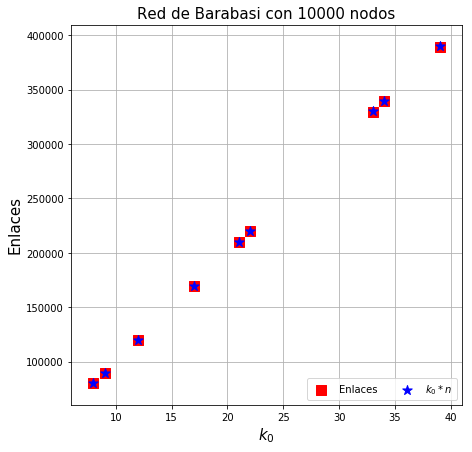

In [46]:
fig, ax = plt.subplots(figsize = (7,7))
plt.xlabel('$k_0$', size = 15)
plt.ylabel('Enlaces',  horizontalalignment='right', x=1.0, y = 0.55, size = 15)
plt.title(f'Red de Barabasi con {n} nodos', fontsize = 15)

for key in m_dict.keys():
    
    scatter1 = ax.scatter(key, m_dict[key][0], c = 'r', alpha = 1, marker = 's', s = 100)
    scatter2 = ax.scatter(key, key * n, c = 'b', alpha = 1, marker = '*', s = 100)

ax.legend((scatter1, scatter2),
           ('Enlaces', '$k_0 * n$'),
           scatterpoints=1,
           loc='lower right',
           ncol=3,
           fontsize=10)

plt.grid()
plt.show()   

Creo funcion que acepte $n$ (nodos, como antes) y $m$ (enlaces) como parámetros para realizar una Red Barabasi. 

In [47]:
def Red_barabasi(n, m):
    k_0 = int(m / n)
    red = barabasi(k_0, n)
    return red

## Inciso (d)

Por cada red del **ejercicio 1**, es decir con su $n$ y $m$, creamos 3 redes con los métodos implementados en este ejercicio. Por cada red creamos una Erdos Reyni, una aleatoria y una Barabasi. 

¿Qué tipo de red da una distribución más parecida a las de los datos? ¿Es posible extraer una conclusión general
sobre el mecanismo de generación de estas redes?

Creamos un diccionario con las redes del **ejercicio 1** y para cada una su $n$ (nodos) y $m$ (enlaces).

In [48]:
Grafo_dict = {}
for red in redes:
    grafo, _ = info_red(redes[red])
    Grafo_dict[red] = {}
    Grafo_dict[red]["Grafo"] = grafo
    Grafo_dict[red]["Nodos"] = grafo.number_of_nodes()
    Grafo_dict[red]["Enlaces"] = grafo.number_of_edges()

In [49]:
Grafo_dict

{'Y2H': {'Grafo': <networkx.classes.graph.Graph at 0x7fad0af2eef0>,
  'Nodos': 2018,
  'Enlaces': 2930},
 'Sistema Electrico': {'Grafo': <networkx.classes.graph.Graph at 0x7fad0af20e80>,
  'Nodos': 4941,
  'Enlaces': 6594},
 'Papers': {'Grafo': <networkx.classes.graph.Graph at 0x7fac8728feb8>,
  'Nodos': 1450,
  'Enlaces': 2727},
 'Internet': {'Grafo': <networkx.classes.graph.Graph at 0x7fac86d9ba58>,
  'Nodos': 22941,
  'Enlaces': 48372}}

Creamos para cada red del **ejercicio 1** tres redes (Erdos Reyni, Aleatoria y Barabasi) con la misma cantidad de nodos y enlaces que las originales.

In [50]:
for red in Grafo_dict:
    n = Grafo_dict[red]['Nodos']
    m = Grafo_dict[red]['Enlaces'] 
    
    start = time.time() #tarda para la red de Internet
    Grafo_dict[red]["Barabasi"] = {}
    Grafo_dict[red]["Barabasi"]["Grafo"] = Red_barabasi(n,m)
    time_bara = time.time()
    print(f'Listo red {red} Barabasi. Tarda {round(time_bara - start,2)} s')
    
    Grafo_dict[red]["Erdos Renyi"] = {}
    Grafo_dict[red]["Erdos Renyi"]["Grafo"] = Red_Erdos_Renyi(n,m)
    time_erdos = time.time()
    print(f'Listo red {red} Erdos. Tarda {round(time_erdos - time_bara, 2)} s')
    
    Grafo_dict[red]["Aleatoria"] = {}
    Grafo_dict[red]["Aleatoria"]["Grafo"] = Red_aleatoria(n,m)
    time_ale = time.time()
    print(f'Listo red {red} Aleatoria. Tarda {round(time_ale - time_erdos,2)} s')
    
    print(f'Terminada red {red}! \n')

Listo red Y2H Barabasi. Tarda 0.69 s
Listo red Y2H Erdos. Tarda 0.19 s
Listo red Y2H Aleatoria. Tarda 0.09 s
Terminada red Y2H! 

Listo red Sistema Electrico Barabasi. Tarda 3.4 s
Listo red Sistema Electrico Erdos. Tarda 1.08 s
Listo red Sistema Electrico Aleatoria. Tarda 0.96 s
Terminada red Sistema Electrico! 

Listo red Papers Barabasi. Tarda 0.39 s
Listo red Papers Erdos. Tarda 0.1 s
Listo red Papers Aleatoria. Tarda 0.04 s
Terminada red Papers! 

Listo red Internet Barabasi. Tarda 76.6 s
Listo red Internet Erdos. Tarda 23.46 s
Listo red Internet Aleatoria. Tarda 1.81 s
Terminada red Internet! 



Para cada red hacemos un gráfico para visualizar en principio los grados.

In [51]:
models = ["Barabasi", "Erdos Renyi", "Aleatoria"]

for red in Grafo_dict:
    Grados = Grafo_dict[red]["Grafo"].degree()
    lista_grados = [val for (node, val) in Grados]
    Grafo_dict[red]["Lista grados"] = lista_grados
    
    for model in models:
        Grados = Grafo_dict[red][model]["Grafo"].degree()
        lista_grados= [val for (node, val) in Grados]
        Grafo_dict[red][model]["Lista grados"] = lista_grados

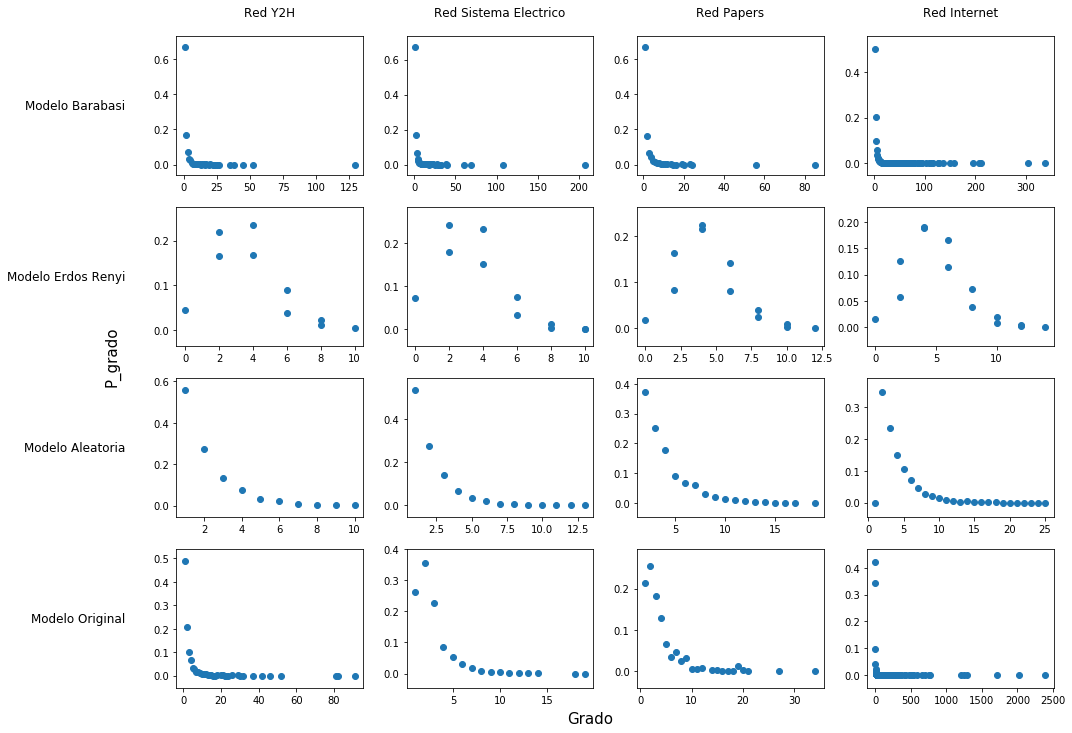

In [52]:
fig, axes = plt.subplots(nrows = 4,ncols = len(Grafo_dict), figsize = (15, 10))
cols = [f'Red {red}' for red in Grafo_dict]
rows = ['Modelo {}'.format(row) for row in ['Barabasi', 'Erdos Renyi', 'Aleatoria', 'Original']]

pad = 20
for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

for i,red in enumerate(Grafo_dict):
    x0,y0 = distribucion_grado_normal(Grafo_dict[red]['Barabasi']["Lista grados"])
    x1, y1 = distribucion_grado_normal(Grafo_dict[red]["Erdos Renyi"]["Lista grados"])
    x2, y2 = distribucion_grado_normal(Grafo_dict[red]['Aleatoria']["Lista grados"])
    x3, y3 = distribucion_grado_normal(Grafo_dict[red]["Lista grados"])
    axes[0,i].scatter(x0,y0)
    axes[1,i].scatter(x1,y1)
    axes[2,i].scatter(x2,y2)
    axes[3,i].scatter(x3,y3)

fig.text(0.55, -0.01, 'Grado', ha='center', size = 15)
fig.text(0.1, 0.5, 'P_grado', va='center', rotation='vertical',  size = 15)
plt.tight_layout()
plt.show()

Se puede observar que las redes generadas por el algoritmo Erdos Reyni tiene una distribución de grado con propiedades de la distribución de Poisson. Mientras que el modelo de Barabási genera redes libres de escala al usar crecimiento y conexión preferencial.

Para verlo mejor utilizamos bineado acumulativo.

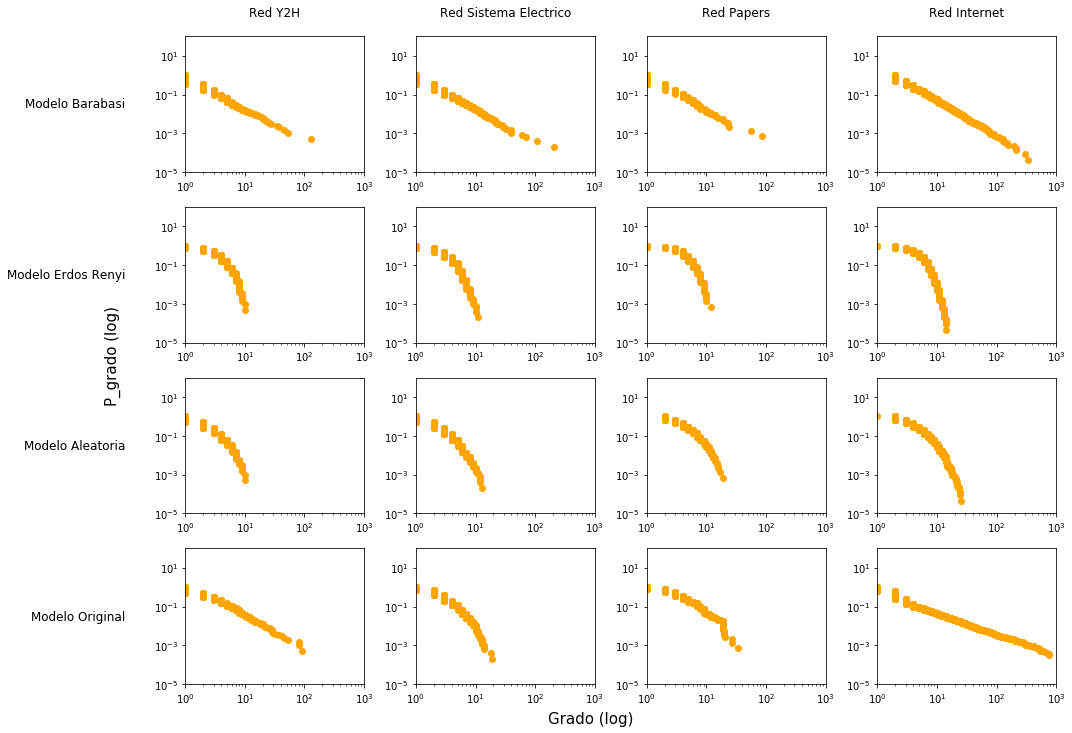

In [64]:
fig, axes = plt.subplots(nrows = 4,ncols = len(Grafo_dict), figsize = (15, 10))
cols = [f'Red {red}' for red in Grafo_dict]
rows = ['Modelo {}'.format(row) for row in ['Barabasi', 'Erdos Renyi', 'Aleatoria', 'Original']]

pad = 20
for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

for i,red in enumerate(Grafo_dict):
    x0,y0 = cumulative_binning(Grafo_dict[red]['Barabasi']["Lista grados"])
    x1, y1 = cumulative_binning(Grafo_dict[red]["Erdos Renyi"]["Lista grados"])
    x2, y2 = cumulative_binning(Grafo_dict[red]['Aleatoria']["Lista grados"])
    x3, y3 = cumulative_binning(Grafo_dict[red]["Lista grados"])
    data  = [(x0,y0), (x1,y1), (x2,y2), (x3, y3)]
    for j, tupla in enumerate(data):
        axes[j,i].scatter(tupla[0], tupla[1], c = "orange")
        axes[j,i].set_yscale("log")
        axes[j,i].set_xscale("log")
        axes[j,i].set_xlim(10**0,10**3)
        axes[j,i].set_ylim(10**-5,10**2)
        
        
fig.text(0.55, -0.01, 'Grado (log)', ha='center', size = 15)
fig.text(0.1, 0.5, 'P_grado (log)', va='center', rotation='vertical',  size = 15)
plt.tight_layout()
plt.show()

Realizamos un gráfico por red que muestra la red original junto con el modelo aleatorio que mejor la imita. 

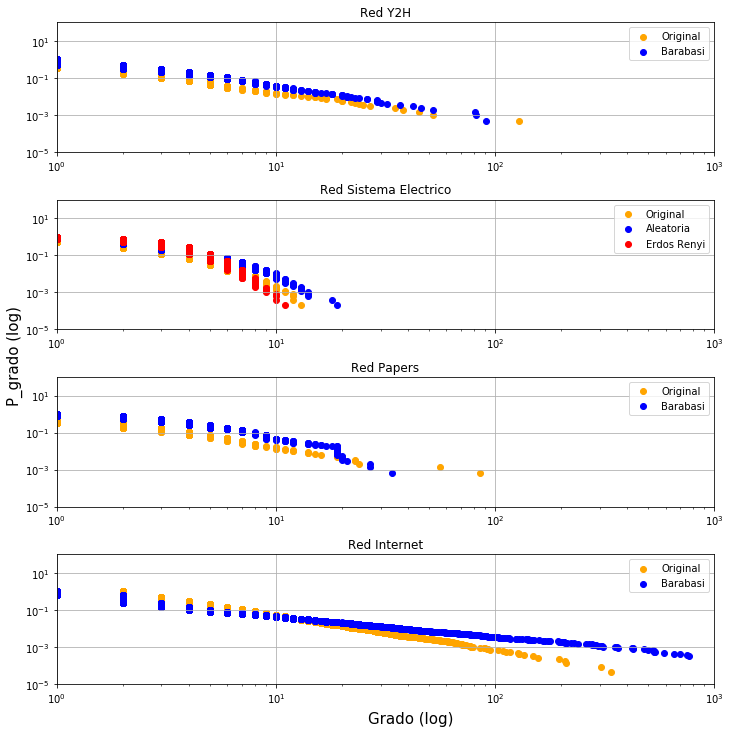

In [65]:
best_fit = [("Y2H", "Barabasi"), ("Sistema Electrico", "Aleatoria", "Erdos Renyi"), ("Papers", "Barabasi"), ("Internet", "Barabasi")]
fig, axes = plt.subplots(nrows = 4,ncols = 1, figsize = (10, 10))

for i,red in enumerate(best_fit):
    x0,y0 = cumulative_binning(Grafo_dict[red[0]][red[1]]["Lista grados"])
    x1, y1 = cumulative_binning(Grafo_dict[red[0]]["Lista grados"])
    axes[i].scatter(x0, y0, c = "orange", label = "Original")
    axes[i].scatter(x1, y1, c = "blue", label = red[1])
    if len(red) == 3:
        x2,y2 = cumulative_binning(Grafo_dict[red[0]][red[2]]["Lista grados"])
        axes[i].scatter(x2, y2, c = "red", label = red[2])
    
    axes[i].set_yscale("log")
    axes[i].set_xscale("log")
    axes[i].set_xlim(10**0,10**3)
    axes[i].set_ylim(10**-5,10**2)
    axes[i].set_title(f"Red {red[0]}")
    axes[i].legend()
    axes[i].grid()

fig.text(0.55, -0.01, 'Grado (log)', ha='center', size = 15)
fig.text(-0.01, 0.5, 'P_grado (log)', va='center', rotation='vertical',  size = 15)
plt.tight_layout()
plt.show()        

# Ejercicio 3
Construímos una red de tipo Barabasi con $n = 10000$ y $k_0 = 7$. Tomamos los 2 nodos
agregados en los pasos 5 y 95 para analiazar el grado de estos nodos en función
de los pasos siguientes. 

In [78]:
"""Esta funcion es la misma que el 2C,
pero ahora guarda la informacion de los nodos agregados en el paso 5 y el paso 95"""

def barabasi_mod(m, final_nodes):
    #m es el grado de los nodos iniciales y a la vez la cantidad de enlaces que agrego por iteracion
    
    node_5 = []
    node_95 = []
    new_node = m + 1 
        
    G = nx.complete_graph(m)
    G_dict = {key: m-1 for key in range(m)}
    
    for step in range(final_nodes - m):
        nodes_to_add = add_edges_mod(G_dict, m)      
        G.add_node(new_node)
        G_dict[new_node] = m
        
         #Aca esta el agregado:
        for node in nodes_to_add:
            G.add_edge(new_node, node)
            G_dict[node] += 1
        
                
        if G_dict.get(m + 5):
            degree_5 = G_dict[m + 5]
            node_5.append(degree_5)
        
            
        if G_dict.get(m + 95):
            degree_95 = G_dict[m + 95]
            node_95.append(degree_95)
        
        new_node += 1
        
    return G,node_5, node_95


        
def add_edges(G_dict, k_0):
    nodes_probs = []
    nodes = list(G_dict.keys())
    total_degree = sum(G_dict.values())
    
    for node in nodes:
        node_degr = G_dict[node]
        node_prob = node_degr / total_degree if total_degree > 0 else 1/len(nodes) #excepción por si no tiene grado
        nodes_probs.append(node_prob) #probabilidad definida en el enunciado
        
    random_nodes = np.random.choice(nodes, size = k_0, p = nodes_probs, replace = False) #no elige dos veces el mismo
             
    return random_nodes

Creamos una red de $10000$ nodos y $k_0$ igual a $7$. 

In [79]:
n_3 = 10000
k_0_3 = 7

Network_3, grado_5, grado_95 = barabasi_mod(k_0_3,n_3)

Graficamos el grado de los nodos elegidos en escala logarítmica en ambos ejes. 

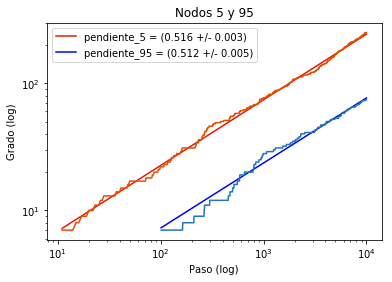

In [80]:
x_5 = list(range(k_0_3 -1 + 5, n_3))
x_5_log = np.log(x_5)
y_5 = grado_5
y_5_log = np.log(y_5)

values_5, cov_5 = np.polyfit(x_5_log, y_5_log, 1, cov = True)
lineal_5 = np.poly1d(values_5)
error_5 = np.sqrt(cov_5[1][1])
yfit_5 = lambda x: np.exp(lineal_5(np.log(x))) #para poder plotear en loglog

plt.loglog(x_5, yfit_5(x_5), label= f'pendiente_5 = ({np.round(lineal_5[1],3)} +/- {np.round(error_5, 3)})',c=(0.9,0.1,0))
plt.loglog(x_5, y_5 , c=(0.9,0.3,0))

x_95 = list(range(k_0_3 -1 + 95, n_3))
x_95_log = np.log(x_95)
y_95 = grado_95
y_95_log = np.log(y_95)

values_95, cov_95 = np.polyfit(x_95_log, y_95_log, 1, cov=True)
error_95 = np.sqrt(cov_95[1][1])
lineal_95 = np.poly1d(values_95)
yfit_95 = lambda x: np.exp(lineal_95(np.log(x))) #para poder plotear en loglog

plt.loglog(x_95, yfit_95(x_95), c='b', label= f'pendiente_95 = ({np.round(lineal_95[1],3)} +/- {np.round(error_95, 3)})')
plt.loglog(x_95, y_95)
plt.xlabel("Paso (log)")
plt.ylabel("Grado (log)")
plt.title("Nodos 5 y 95")
plt.legend()
plt.show()

El grado de cada nodo aumenta siguiendo una ley de potencias con el mismo exponente. Este pendiente es menor a $1$, cada nodo que se agrega tiene más nodos para "elegir", es decir hay más nodos que "compiten" por aumentar su grado. A su vez, los nodos agregados antes tienen mayor grado (por ende, más ventaja a la hora de conseguir nuevos enlaces). 